# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### Подготовка окружения (пути, seed, imports)

In [1]:
import os
import random
import re
from collections import Counter
from typing import List, Tuple, cast

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score as f1_score_ner
from sklearn.metrics import f1_score as f1_score_cls
from sklearn.metrics import precision_score, recall_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    AutoModel,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def fix_all_seeds(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Все сиды зафиксированы: {seed}")


RANDOM_SEED = 42
fix_all_seeds(RANDOM_SEED)

DATA_DIR = "data/"
# MODEL_SAVE_PATH = './models/'

data_train_path = os.path.join(DATA_DIR, "train.jsonl")
data_val_path = os.path.join(DATA_DIR, "dev.jsonl")
data_test_path = os.path.join(DATA_DIR, "test.jsonl")

data_entities_path = os.path.join(DATA_DIR, "ent_types.jsonl")
data_relations_path = os.path.join(DATA_DIR, "rel_types.jsonl")

Все сиды зафиксированы: 42


In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set_style("white")
sns.set_theme(style="whitegrid")

##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [5]:
# Читаем и отображаем первые 200 строк тренировочного датасета
data_train = pd.read_json(
    data_train_path,
    lines=True,
).head(
    200
)  # nrows=200)
display(data_train)
# Проверяем типы данных в столбцах 'entities' и 'relations'
first_item = data_train["entities"].iloc[0]
display(f"Тип в первой строке признака entities {type(first_item)}")
first_item = data_train["relations"].iloc[0]
display(f"Тип в первой строке признака relations {type(first_item)}")

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШ...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY 82 89\tБишкеке, T3\tDATE 117 126\t5 августа, T4\tCOUNTRY 136 142\tГру...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE_IS Arg1:T101 Arg2:T13, R3\tHEADQUARTERED_IN Arg1:T72 Arg2:T4, R4\tHEA...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\tReference T10 Wikidata:Q6589202\tминистерство внутренних дел, N3\tRef..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Башкирии Муртаза Рахимов в очередной раз решил поменять главу своей адми...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESSION 31 40\tПрезидент, T3\tPERSON 50 65\tМуртаза Рахимов, T4\tPROFESSIO...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS Arg1:T8 Arg2:T9, R3\tWORKPLACE Arg1:T78 Arg2:T80, R4\tAGE_IS Arg1:T18 A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReference T10 Wikidata:NULL\t, N3\tReference T13 Wikidata:NULL\t, N4\tReferen..."
2,2,"Россия задерживает поставку генсека\n\t\nСегодня в Дохе открывается заседание Форума стран-экспортеров газа (ФСЭГ), ...","[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе, T3\tDATE 38 45\tСегодня, T4\tORGANIZATION 75 104\tФорума стран-экспо...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORGANIZES Arg1:T4 Arg2:T124, R3\tTAKES_PLACE_IN Arg1:T124 Arg2:T2, R4\tPO...","[N1\tReference T5 Wikidata:Q1031255\tФорум стран-экспортёров газа, N2\tReference T18 Wikidata:Q656\tСанкт-Петербург,..."
3,3,"Российские менеджеры отказались возглавлять ""газовую ОПЕК""\nПравительство России не смогло найти кандидатуру генерал...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATION 59 72\tПравительство, T3\tPROFESSION 108 130\tгенерального секретаря...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tALTERNATIVE_NAME Arg1:T80 Arg2:T97, R3\tTAKES_PLACE_IN Arg1:T8 Arg2:T9, ...","[N1\tReference T3 Wikidata:Q6501749\tгенеральный секретарь, N2\tReference T5 Wikidata:Q1780189\tКоммерсантъ, N3\tRef..."
4,4,Facebook нашел нового финансового директора\nФинансовым директором социальной сети Facebook назначен 39-летний Дэвид...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSION 22 43\tфинансового директора, T3\tPROFESSION 44 65\tФинансовым дирек...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_NAME Arg1:T6 Arg2:T7, R3\tWORKPLACE Arg1:T6 Arg2:T4, R4\tWORKS_AS Arg1:...","[N1\tReference T13 Wikidata:Q899140\tGenentech, N2\tReference T26 Wikidata:Q5233251\tДэвид Эберсман, N3\tReference T..."
...,...,...,...,...,...
195,195,Состоялось открытие выставки «„Песочные часы“: Рисунки Иосифа Бродского»\nНакануне в зале Корфа в Главном здании Рос...,"[T1\tEVENT 30 71\t„Песочные часы“: Рисунки Иосифа Бродского, T2\tPERSON 161 177\tИосифа Бродского, T3\tPERSON 55 71\...","[R1\tHEADQUARTERED_IN Arg1:T23 Arg2:T22, R2\tOWNER_OF Arg1:T23 Arg2:T4, R3\tPART_OF Arg1:T20 Arg2:T4, R4\tWORKS_AS A...","[N1\tReference T3 Wikidata:Q862\tИосиф Александрович Бродский, N2\tReference T4 Wikidata:NULL\t, N3\tReference T10 W..."
196,196,"Теракт в Иерусалиме: убиты двое полицейских\nПогибшие в результате теракта полицейские\nВ пятницу, 14 июля 2017 года...","[T1\tEVENT 0 6\tТеракт, T2\tCITY 9 19\tИерусалиме, T3\tNUMBER 27 31\tдвое, T4\tDATE 86 114\tВ пятницу, 14 июля 2017 ...","[R1\tLOCATED_IN Arg1:T6 Arg2:T5, R2\tLOCATED_IN Arg1:T5 Arg2:T61, R3\tLOCATED_IN Arg1:T9 Arg2:T10, R4\tLOCATED_IN Ar...","[N1\tReference T5 Wikidata:Q212938\tВосточный Иерусалим, N2\tReference T9 Wikidata:Q1450403\tЛьвиные ворота, N3\tRef..."
197,197,Многодетный хакер из Тюмени осуждён за взлом восьми сайтов\nНоутбук Asus\nТюменский районный суд вынес приговор в от...,"[T1\tCITY 21 27\tТюмени, T2\tNUMBER 45 51\tвосьми, T3\tPRODUCT 67 71\tAsus, T4\tAGE 122 132\t36-летнего, T5\tPERSON ...","[R1\tHEADQUARTERED_IN Arg1:T23 Arg2:T24, R2\tAGE_IS Arg1:T5 Arg2:T4, R3\tALTERNATIVE_NAME Arg1:T5 Arg2:T10, R4\tHEAD...","[N1\tReference T5 Wikidata:Q4212355\tКандыба, Андрей Фёдорович, N2\tReference T6 Wikidata:NULL\t, N3\tReference T12 ..."


"Тип в первой строке признака entities <class 'list'>"

"Тип в первой строке признака relations <class 'list'>"

In [6]:
# Читаем и отображаем типы сущностей из файла ent_types.jsonl
data_ent_types = pd.read_json(data_entities_path, lines=True)
display(data_ent_types.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
type,AGE,AWARD,CITY,COUNTRY,CRIME,DATE,DISEASE,DISTRICT,EVENT,FACILITY,FAMILY,IDEOLOGY,LANGUAGE,LAW,LOCATION,MONEY,NATIONALITY,NUMBER,ORDINAL,ORGANIZATION,PENALTY,PERCENT,PERSON,PRODUCT,PROFESSION,RELIGION,STATE_OR_PROVINCE,TIME,WORK_OF_ART
link,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata,,,<NORM>:Wikidata,,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata


In [7]:
# Читаем и отображаем типы отношений из файла rel_types.jsonl
data_rel_types = pd.read_json(data_relations_path, lines=True)
display(data_rel_types)

,type,arg1,arg2
0,ABBREVIATION,[<ENTITY>],[<ENTITY>]
1,KNOWS,"[PERSON, PROFESSION]",[<ENTITY>]
2,AGE_IS,[<ENTITY>],[AGE]
3,AGE_DIED_AT,"[PERSON, PROFESSION]",[AGE]
4,ALTERNATIVE_NAME,[<ENTITY>],[<ENTITY>]
5,AWARDED_WITH,"[PERSON, PROFESSION, ORGANIZATION, WORK_OF_ART, NATIONALITY]",[AWARD]
6,PLACE_OF_BIRTH,"[PERSON, PROFESSION]","[CITY, COUNTRY, DISTRICT, FACILITY, LOCATION, STATE_OR_PROVINCE]"
7,CAUSE_OF_DEATH,"[PERSON, PROFESSION, NATIONALITY]","[DISEASE, EVENT]"
8,DATE_DEFUNCT_IN,"[CITY, COUNTRY, DISTRICT, FACILITY, EVENT, ORGANIZATION, STATE_OR_PROVINCE, WORK_OF_ART]",[DATE]
9,DATE_FOUNDED_IN,"[CITY, COUNTRY, DISTRICT, FACILITY, EVENT, LOCATION, ORGANIZATION, STATE_OR_PROVINCE, WORK_OF_ART]",[DATE]


In [8]:
# Подсчёт количества сущностей по типам в тренировочном датасете
entity_counts = Counter()

for entities_list in data_train["entities"]:
    for entity_string in entities_list:
        # Разрезаем по табуляции и берем вторую часть
        # "T1\tNATIONALITY 62 74\tамериканцами" -> "NATIONALITY 62 74"
        parts = entity_string.split("\t")
        if len(parts) > 1:
            # Берем первое слово из второй части: "NATIONALITY"
            ent_type = parts[1].split(" ")[0]
            entity_counts[ent_type] += 1

display(entity_counts.most_common())

[('PERSON', 2055),
 ('PROFESSION', 1893),
 ('ORGANIZATION', 1692),
 ('DATE', 1125),
 ('COUNTRY', 1024),
 ('EVENT', 986),
 ('CITY', 467),
 ('NUMBER', 399),
 ('LAW', 240),
 ('AGE', 215),
 ('NATIONALITY', 186),
 ('ORDINAL', 182),
 ('FACILITY', 159),
 ('AWARD', 156),
 ('IDEOLOGY', 149),
 ('STATE_OR_PROVINCE', 132),
 ('WORK_OF_ART', 126),
 ('DISEASE', 112),
 ('CRIME', 99),
 ('MONEY', 96),
 ('PRODUCT', 81),
 ('LOCATION', 79),
 ('PENALTY', 66),
 ('DISTRICT', 63),
 ('TIME', 57),
 ('RELIGION', 26),
 ('PERCENT', 16),
 ('FAMILY', 15),
 ('LANGUAGE', 14)]

In [9]:
# Подсчёт количества отношений по типам в тренировочном датасете
relations_counts = Counter()

for relations_list in data_train["relations"]:
    for relation_string in relations_list:
        # Разрезаем по табуляции и берем вторую часть
        parts = relation_string.split("\t")
        if len(parts) > 1:
            relation_type = parts[1].split(" ")[0]
            relations_counts[relation_type] += 1

display(relations_counts.most_common())

[('WORKPLACE', 1080),
 ('WORKS_AS', 961),
 ('ALTERNATIVE_NAME', 927),
 ('PARTICIPANT_IN', 807),
 ('ORIGINS_FROM', 452),
 ('HEADQUARTERED_IN', 424),
 ('POINT_IN_TIME', 407),
 ('TAKES_PLACE_IN', 360),
 ('LOCATED_IN', 270),
 ('AGENT', 266),
 ('AGE_IS', 182),
 ('PRODUCES', 164),
 ('AWARDED_WITH', 125),
 ('HAS_CAUSE', 121),
 ('IDEOLOGY_OF', 105),
 ('MEMBER_OF', 101),
 ('PART_OF', 99),
 ('PARENT_OF', 89),
 ('SUBORDINATE_OF', 87),
 ('PLACE_RESIDES_IN', 83),
 ('INANIMATE_INVOLVED', 68),
 ('MEDICAL_CONDITION', 68),
 ('CONVICTED_OF', 66),
 ('DATE_OF_CREATION', 66),
 ('KNOWS', 64),
 ('OWNER_OF', 63),
 ('ABBREVIATION', 57),
 ('SUBEVENT_OF', 51),
 ('SIBLING', 51),
 ('ORGANIZES', 49),
 ('FOUNDED_BY', 49),
 ('DATE_OF_BIRTH', 42),
 ('SPOUSE', 40),
 ('PLACE_OF_BIRTH', 37),
 ('DATE_OF_DEATH', 35),
 ('RELIGION_OF', 27),
 ('PENALIZED_AS', 26),
 ('PLACE_OF_DEATH', 26),
 ('AGE_DIED_AT', 24),
 ('INCOME', 23),
 ('SCHOOLS_ATTENDED', 21),
 ('PRICE_OF', 21),
 ('EXPENDITURE', 16),
 ('DATE_FOUNDED_IN', 16),
 ('STA

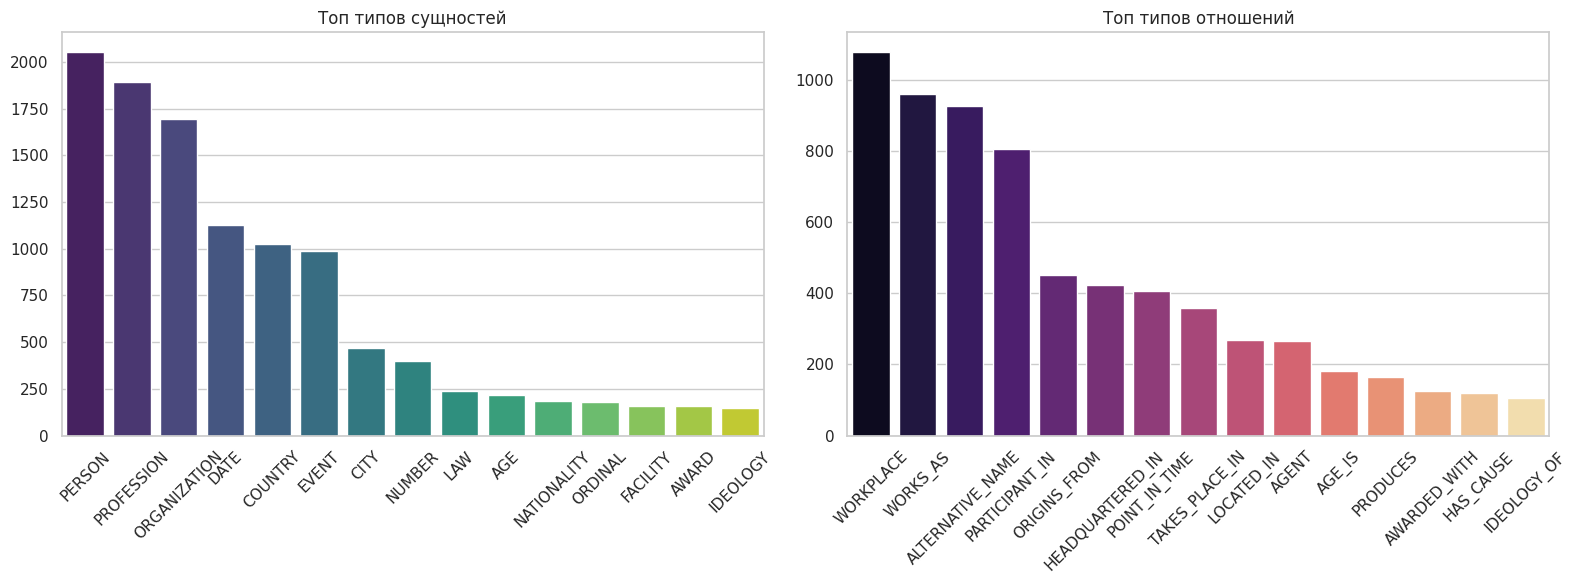

In [10]:
# Визуализация распределения типов сущностей и отношений
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
entity_types, entity_values = zip(*entity_counts.most_common(15))
relation_types, relation_values = zip(*relations_counts.most_common(15))

sns.barplot(
    x=entity_types,
    y=entity_values,
    ax=ax[0],
    palette="viridis",
    hue=entity_types,
    legend=False,
)
ax[0].set_title("Топ типов сущностей")
ax[0].tick_params(axis="x", rotation=45)


sns.barplot(
    x=relation_types,
    y=relation_values,
    ax=ax[1],
    palette="magma",
    hue=relation_types,
    legend=False,
)
ax[1].set_title("Топ типов отношений")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

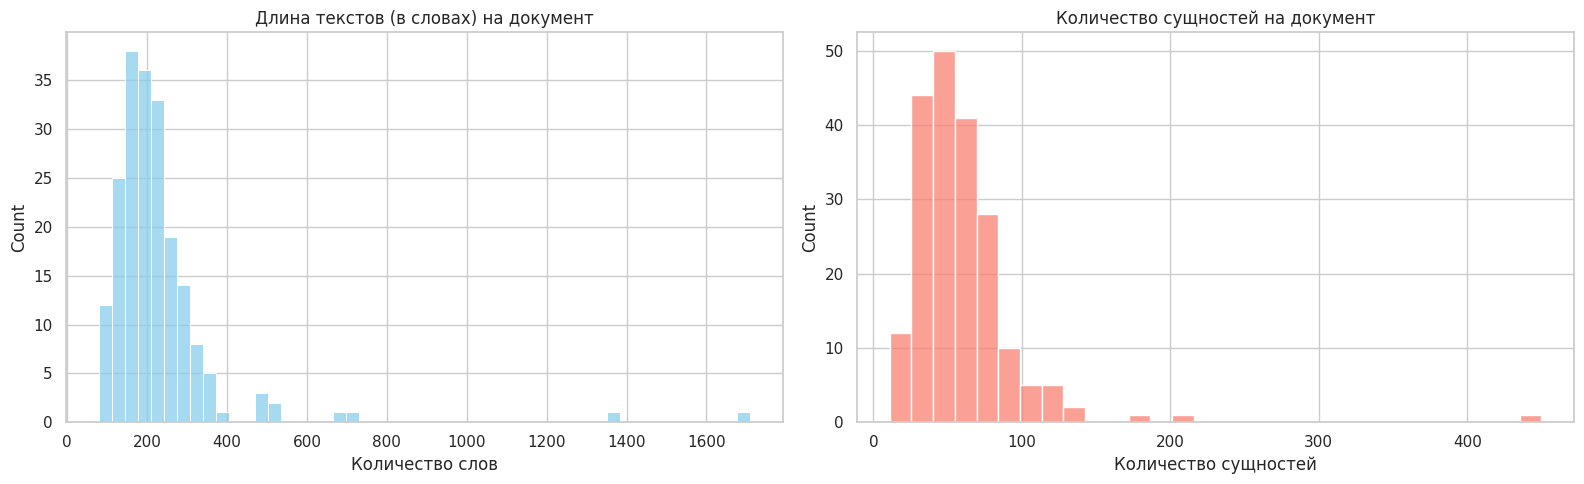

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Левый график: Длина текста
text_lens = data_train["text"].apply(lambda x: len(x.split()))
sns.histplot(x=text_lens, ax=ax[0], bins=50, color="skyblue")
ax[0].set_title("Длина текстов (в словах) на документ")
ax[0].set_xlabel("Количество слов")

# Правый график: Кол-во сущностей
ent_counts = data_train["entities"].apply(len)
sns.histplot(x=ent_counts, ax=ax[1], bins=30, color="salmon")
ax[1].set_title("Количество сущностей на документ")
ax[1].set_xlabel("Количество сущностей")

plt.tight_layout()
plt.show()

In [12]:
text_lens.describe()

count     200.0000
mean      227.6600
std       163.2002
min        79.0000
25%       154.0000
50%       199.0000
75%       257.0000
max     1,710.0000
Name: text, dtype: float64

In [13]:
ent_counts.describe()

count   200.0000
mean     59.5500
std      39.1890
min      11.0000
25%      39.0000
50%      53.0000
75%      70.0000
max     450.0000
Name: entities, dtype: float64

##### Выводы

1. Дисбаланс классов (Long-tail distribution)
Наблюдение: Наблюдается сильный дисбаланс как в сущностях, так и в отношениях.
Сущности: Топ-3 (PERSON, PROFESSION, ORGANIZATION) составляют почти 50% всех текстов. В то же время есть «хвост» из редких классов (RELIGION, PERCENT, FAMILY, LANGUAGE), где менее 30 примеров на весь датасет.
Отношения: Та же картина. Отношения вроде WORKPLACE (1080) против DATE_DEFUNCT_IN (4).
Модель может хорошо выучить мажоритарные классы, но будет иметь низкий Recall на редких.
Возможное решение: Для валидации использовать F1-macro (а не accuracy), чтобы редкие классы не потерялись. Для обучения стоит рассмотреть Weighted Cross-Entropy или Focal Loss, чтобы увеличить штраф за ошибку на редких классах.
2. Экстремальная плотность сущностей
Наблюдение: Средняя длина текста — 227 слов, среднее количество сущностей — 59.5.
Это означает, что каждое 4-е слово в тексте является частью какой-то сущности. Это очень высокая плотность.
Тексты сильно насыщены терминологией и фактами. Модель будет получать сильный сигнал для обучения классов B и I, и проблема «засилья пустого класса O» здесь стоит не так остро.
Риск: Из-за плотности сущности часто стоят вплотную друг к другу. Модели может быть сложно разделять границы (Boundary detection) между соседними сущностями одного типа.
3. Проблема длины последовательности (Truncation issue)
Наблюдение: Средняя длина 227 слов (~300-350 токенов) укладывается в лимит BERT (512), но max = 1710 слов значительно его превышает.
При простом подходе (обрезка до 512) мы потеряем данные в длинных документах. В 25% документов (те, что выше 3-го квартиля) часть текста будет отрезана.
Решение: Необходимо внедрить стратегию Sliding Window (скользящее окно) с перекрытием (overlap), чтобы не потерять сущности и отношения в хвостах длинных документов.
4. Сложность задачи извлечения отношений (RE)
Наблюдение: Количество отношений (например, WORKPLACE: 1080) сопоставимо с количеством сущностей (ORGANIZATION: 1692).
Почти каждая организация в тексте связана с каким-то WORKPLACE.
Для классов с количеством примеров < 10-20 (напр. DATE_DEFUNCT_IN, END_TIME) обучение стандартным классификатором практически невозможно (не хватит данных для разделения в пространстве).
Решение: Эти классы либо стоит объединить в группу «OTHER», либо использовать Few-shot learning подходы, либо признать их нерелевантными для данной итерации обучения.
5. Аномальные документы (Outliers)
Наблюдение: Документ с 450 сущностями при среднем 59.
В данных есть аномальные документы (возможно, списки, таблицы или реестры), которые резко отличаются от связного текста.
Решение: Провести ручную проверку документов с entities > 200, чтобы убедиться в качестве разметки и решить, не будут ли они сбивать модель с толку (нормальный это язык или просто список имен).
6. Датасет представлен в standoff-формате, что позволило сохранить оригинальный текст документов и реализовать многоуровневую разметку (сущности + отношения).

Что дальше:
Токенизация: Использовать AutoTokenizer от DeepPavlov/rubert-base-cased (так как регистр важен для PERSON и ORGANIZATION).
Архитектура: BERT + Dropout + Linear Layer (для NER).
Стратегия: Sliding window для текстов > 512 токенов.
Метрики: Считать F1 отдельно для каждой сущности, чтобы видеть просадки на редких классах.

##### 2. Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [14]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    """
    Парсит строку сущности в формате NEREL и возвращает словарь с её атрибутами.
    Пример строки:
        T1\tORG 0 4\tIBM
    Возвращает:
        {
            'id': 'T1',
            'type': 'ORG',
            'start': 0,
            'end': 4,
            'text': 'IBM'
        }
    """
    parts = line.split("\t")
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ""
    m = re.match(r"(\S+)\s+(\d+)\s+(\d+)", type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {"id": ent_id, "type": ent_type, "start": start, "end": end, "text": text}


def parse_relation_line(line: str):
    """
    Парсит строку отношения в формате NEREL и возвращает словарь с её атрибутами.
    Пример строки:
        R1\tEMPLOYMENT Arg1:T1 Arg2:T2
    Возвращает:
        {
            'id': 'R1',
            'type': 'EMPLOYMENT',
            'arg1': 'T1',
            'arg2': 'T2'
        }
    """
    parts = line.split("\t")
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r"(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)", body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2)
    arg2 = m.group(3)
    return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}

In [15]:
def whitespace_tokenize_with_offsets(text: str):
    """
    Токенизирует текст по пробельным символам и возвращает токены с их смещениями.
    Параметры: text (str) - входной текст
    Пример:
    >>> text = "Hello, world! This is a test."
    >>> tokens, spans = whitespace_tokenize_with_offsets(text)
    >>> print(tokens)
    ['Hello,', 'world!', 'This', 'is', 'a', 'test.']
    >>> print(spans)
    [(0, 6), (7, 13), (14, 18), (19, 21), (22, 23), (24, 29)]
    """
    tokens = []
    token_spans = []
    for m in re.finditer(r"\S+", text):
        tokens.append(m.group())
        token_spans.append((m.start(), m.end()))
    return tokens, token_spans

In [16]:
def map_object_type(obj_type: str) -> str:
    """
    Преобразует оригинальные типы NEREL в упрощенную схему.
    Вход:
        obj_type (str): строка с исходным типом/подтипом сущности из разметки ent_types.jsonl.
    Возвращает:
        str: одна из {'PER', 'PRF', 'ORG', 'DATE', 'LOC', 'EVN', 'NMB', 'LAW', 'AGE','NATN','MISC'}.

    Примеры:
        map_object_type("PERSON") -> "PER"
        map_object_type("PROFESSION") -> "PROFESSION"
        map_object_type("ORGANIZATION") -> "ORG"
        map_object_type("COUNTRY") -> "LOC"
        map_object_type("EVENT") -> "EVENT"
    """
    # Группировка локаций
    if obj_type in ["COUNTRY", "CITY", "STATE_OR_PROVINCE", "DISTRICT", "LOCATION"]:
        return "LOC"
    # Группировка численных (кроме возраста, он важен для отношений)
    if obj_type in ["NUMBER", "ORDINAL"]:
        return "NUM"
    # Меняем персон
    if obj_type in ["PERSON"]:
        return "PER"
    # Меняем организации
    if obj_type in ["ORGANIZATION"]:
        return "ORG"
    # Список тех, что оставляем без изменений (высокий count или важны для RE)
    keep_types = [
        "PROFESSION",
        "EVENT",
        "DATE",
        "LAW",
        "AGE",
        "NATIONALITY",
        "FACILITY",
        "AWARD",
        "IDEOLOGY",
    ]
    if obj_type in keep_types:
        return obj_type
    # Всё остальное (включая < 100 и специфические типы) -> MISC
    return "MISC"

In [17]:
def spans_to_bio(
    tokens_off: List[Tuple[str, int, int]], spans: List[Tuple[int, int, str]]
) -> List[str]:
    """
    Преобразует спаны именованных сущностей в BIO-метки для токенов.
    Ввод:
    - tokens_off: List of tuples (token, start_offset, end_offset)
    - spans: List of tuples (span_start, span_end, label)
    Вывод: List of BIO labels corresponding to each token
    Пример:
    >>> tokens_off = [("Hello", 0, 5), (",", 5, 6), ("world", 7, 12), ("!", 12, 13)]
    >>> spans = [(0, 5, "GREETING"), (7, 12, "OBJECT")]
    >>> spans_to_bio(tokens_off, spans)
    ['B-GREETING', 'O', 'B-OBJECT', 'O']
    """
    # Инициализируем все метки как 'O' (Outside)
    bio = ["O"] * len(
        tokens_off
    )  # Ваш код здесь - создайте список из 'O' длиной, равной количеству токенов

    # Обрабатываем каждый спан сущности
    for span_start, span_end, label in spans:
        first_token_in_span = True  # флаг для отслеживания первого токена в спане

        # Проверяем каждый токен на пересечение с текущим спаном
        for i, (token, t_start, t_end) in enumerate(tokens_off):

            # Проверяем, пересекается ли токен со спаном
            # Условие НЕпересечения: токен полностью до спана ИЛИ полностью после спана
            if t_end <= span_start or t_start >= span_end:
                continue  # токен не пересекается со спаном, переходим к следующему

            # Токен пересекается со спаном!
            if first_token_in_span:
                # Это первый токен в данном спане - помечаем как B-LABEL
                bio[i] = f"B-{label}"
                first_token_in_span = False
            else:
                # Это НЕ первый токен в спане - помечаем как I-LABEL
                bio[i] = f"I-{label}"

    return bio

In [18]:
def make_event_list(records: List[dict], K=30):
    """
    Создает список из K наиболее частых типов событий в корпусе записей.
    Параметры:
        records: список словарей типа {id: int, text: str, entities: List[str], relations: List[str]}
        K: количество топовых типов событий для возврата
    Возвращает:
        List[str]: список из K наиболее частых типов событий
    Примеры:
        records = [R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE_IS Arg1:T101 Arg2:T13, ...]  # список записей с отношениями
        make_event_list(records, K=10) -> ["TAKES_PLACE_IN", "AGE_IS", ...]
    """
    event_counter = Counter()
    for record in records:
        for line_rel in record['relations']:
            rel_dic = parse_relation_line(line_rel) # return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}
            if rel_dic:
                relation_type = rel_dic['type']
                event_counter[relation_type] += 1
    most_common_events = [etype for etype, _ in event_counter.most_common(K)]
    return most_common_events

In [19]:
def build_examples_from_nerel(records: pd.DataFrame, event_list: List[str]) -> List[dict]:
    """    
    Преобразует записи NEREL в формат примеров с токенами, спанами и BIO-метками.
    Параметры:
        records: pd.DataFrame - DataFrame с записями NEREL
        event_list: List[str] - список типов событий для классификации
    Возвращает:
        List[dict]: список примеров с ключами 'tokens', 'token_spans', 'tags', 'cls_vec'
    Примеры:
        records = pd.DataFrame([...])  # DataFrame с записями NEREL
        event_list = ["TAKES_PLACE_IN", "AGE_IS", ...]  # список типов событий
        build_examples_from_nerel(records, event_list) -> [
            {
                "tokens": [...],
                "token_spans": [...],
                "tags": [...],
                "cls_vec": [...],
            },
            ...
    """
    event_to_id = {name: i for i, name in enumerate(event_list)} # Приготовим маппинг event_name -> index
    print(f"словарь event_list: {event_to_id}")
    examples = []
    for rec in records.to_dict(orient="records"): # Иттерируем по строкам DataFrame
        text = rec["text"]
        tokens, token_spans = whitespace_tokenize_with_offsets(text) # tokens: List[str], token_spans: List[Tuple[int, int]]
        token_labels = ["O"] * len(tokens)


        for entities_list in rec["entities"]:
            # parse_entity_line -> return {"id": ent_id, "type": ent_type, "start": start, "end": end, "text": text}
            entity_dict = parse_entity_line(entities_list)
            # для проверки print('entity_dict=', entity_dict)
            if entity_dict:
                ent_type = entity_dict["type"]
                span_start = entity_dict["start"]
                span_end = entity_dict["end"]
                base_type = map_object_type(ent_type)
                
                overlapping_idxs = []
                # Найдите токены, которые пересекаются с этим спаном
                for i, (t_start, t_end) in enumerate(token_spans):
                    if not (t_end <= span_start or t_start >= span_end):
                        overlapping_idxs.append(i)

                # нет пересечения
                if not overlapping_idxs:
                    # для проверки print(f"No overlap for span {span_start}-{span_end} in doc {rec.id}")
                    continue

                # есть пересечение
                for j, tok_idx in enumerate(overlapping_idxs): # tok_idx - индекс токена в tokens/token_spans
                    if token_labels[tok_idx] != "O": # уже помечен другой сущностью
                        continue
                    prefix = "B" if j == 0 else "I" # первый токен в спане или нет
                    token_labels[tok_idx] = f"{prefix}-{base_type}" 

        # Создаем вектор классификации событий cls_vec                
        cls_vec = np.zeros(len(event_list), dtype=np.float32)
        for relation_string in rec["relations"]:
            rel_dic = parse_relation_line(relation_string) # return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}
            if rel_dic:
                relation_type = rel_dic['type']
                if relation_type in event_to_id:
                    cls_vec[event_to_id[relation_type]] = 1
                
        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec,  # заполним позже
        })

    return examples

In [20]:
records = data_train.to_dict(orient="records")
event_list = make_event_list(records, K=30)
examples = build_examples_from_nerel(data_train, event_list) 
# вывод примеров [{'text: str, tokens: List[str,str, ...], token_spans:[(int,int),(...)...], tags: [str, str, ...], cls_vec: }, {...}]
example = pd.DataFrame(examples).sample(5)
display(example)

словарь event_list: {'WORKPLACE': 0, 'WORKS_AS': 1, 'ALTERNATIVE_NAME': 2, 'PARTICIPANT_IN': 3, 'ORIGINS_FROM': 4, 'HEADQUARTERED_IN': 5, 'POINT_IN_TIME': 6, 'TAKES_PLACE_IN': 7, 'LOCATED_IN': 8, 'AGENT': 9, 'AGE_IS': 10, 'PRODUCES': 11, 'AWARDED_WITH': 12, 'HAS_CAUSE': 13, 'IDEOLOGY_OF': 14, 'MEMBER_OF': 15, 'PART_OF': 16, 'PARENT_OF': 17, 'SUBORDINATE_OF': 18, 'PLACE_RESIDES_IN': 19, 'INANIMATE_INVOLVED': 20, 'MEDICAL_CONDITION': 21, 'CONVICTED_OF': 22, 'DATE_OF_CREATION': 23, 'KNOWS': 24, 'OWNER_OF': 25, 'ABBREVIATION': 26, 'SUBEVENT_OF': 27, 'SIBLING': 28, 'ORGANIZES': 29}


,text,tokens,token_spans,tags,cls_vec
95,Путин подписал распоряжение о выходе России из Международного уголовного суда\n\nРезиденция суда в Гааге\nПрезидент ...,"[Путин, подписал, распоряжение, о, выходе, России, из, Международного, уголовного, суда, Резиденция, суда, в, Гааге,...","[(0, 5), (6, 14), (15, 27), (28, 29), (30, 36), (37, 43), (44, 46), (47, 61), (62, 72), (73, 77), (79, 89), (90, 94)...","[B-PER, B-EVENT, I-EVENT, O, B-EVENT, B-LOC, O, B-ORG, I-ORG, I-ORG, B-FACILITY, I-FACILITY, I-FACILITY, B-LOC, B-PR...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,Главным управляющим General Motors назначен Э.Уитакер.\n\nВременный главный управляющий американского автопризводите...,"[Главным, управляющим, General, Motors, назначен, Э.Уитакер., Временный, главный, управляющий, американского, автопр...","[(0, 7), (8, 19), (20, 27), (28, 34), (35, 43), (44, 54), (56, 65), (66, 73), (74, 85), (86, 99), (100, 116), (117, ...","[B-PROFESSION, I-PROFESSION, B-ORG, I-ORG, B-EVENT, B-PER, B-PROFESSION, I-PROFESSION, I-PROFESSION, B-LOC, O, B-ORG...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,Число кандидатов в мэры Москвы выросло до 13\n\nТринадцатым кандидатом на пост столичного градоначальника стал элект...,"[Число, кандидатов, в, мэры, Москвы, выросло, до, 13, Тринадцатым, кандидатом, на, пост, столичного, градоначальника...","[(0, 5), (6, 16), (17, 18), (19, 23), (24, 30), (31, 38), (39, 41), (42, 44), (46, 57), (58, 68), (69, 71), (72, 76)...","[O, O, O, B-PROFESSION, I-PROFESSION, O, O, B-NUM, B-NUM, O, O, O, B-PROFESSION, I-PROFESSION, O, B-PROFESSION, B-PE...","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
158,"Режиссёр Дэвид Линч уходит из кино\nДэвид Линч\nКультовый американский кинорежиссёр Дэвид Линч объявил, что после вы...","[Режиссёр, Дэвид, Линч, уходит, из, кино, Дэвид, Линч, Культовый, американский, кинорежиссёр, Дэвид, Линч, объявил,,...","[(0, 8), (9, 14), (15, 19), (20, 26), (27, 29), (30, 34), (35, 40), (41, 45), (46, 55), (56, 68), (69, 81), (82, 87)...","[B-PROFESSION, B-PER, I-PER, O, O, O, B-PER, I-PER, O, B-NATIONALITY, B-PROFESSION, B-PER, I-PER, O, O, O, O, O, O, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
128,Глава Samsung арестован по делу о коррупции\n\nЛи Джэён\nЮжнокорейский суд центрального округа Сеула выдал ордер на ...,"[Глава, Samsung, арестован, по, делу, о, коррупции, Ли, Джэён, Южнокорейский, суд, центрального, округа, Сеула, выда...","[(0, 5), (6, 13), (14, 23), (24, 26), (27, 31), (32, 33), (34, 43), (45, 47), (48, 53), (54, 67), (68, 71), (72, 84)...","[B-PROFESSION, B-ORG, B-MISC, O, O, O, B-MISC, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC, I-LOC, B-EVENT, I-EVENT, I-...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."


##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [21]:
# Создаем объект Dataset
dataset = Dataset.from_list(examples)
print(dataset)

Dataset({
    features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
    num_rows: 200
})


In [22]:
# 1. Получаем список всех новых уникальных сущностей из файла словаря ent_types.jsonl
# ['PERSON', 'LOC', 'ORGANIZATION', 'MISC', ...]
unique_entities = sorted(list(set(map_object_type(t) for t in data_ent_types['type'])))
print(f"Уникальные типы сущностей: {unique_entities}")
# 2. Создаем полный список BIO-меток
final_labels = ['O'] # 'O' всегда идет первым (обычно индекс 0)
for ent in unique_entities:
    final_labels.append(f'B-{ent}')
    final_labels.append(f'I-{ent}')

# 3. Создаем два словаря для конвертации туда-сюда
label2id = {label: i for i, label in enumerate(final_labels)}
id2label = {i: label for label, i in label2id.items()}

num_labels = len(final_labels)
print(f"Количество меток NER: {num_labels}")

# Аналогично для CLS (классификация событий)
label2id_cls = {name: i for i, name in enumerate(event_list)} # Приготовим маппинг event_name -> index
id2label_cls = {i: name for name, i in label2id_cls.items()}
num_labels_cls = len(event_list)
print(f"Количество классов CLS: {num_labels_cls}")

Уникальные типы сущностей: ['AGE', 'AWARD', 'DATE', 'EVENT', 'FACILITY', 'IDEOLOGY', 'LAW', 'LOC', 'MISC', 'NATIONALITY', 'NUM', 'ORG', 'PER', 'PROFESSION']
Количество меток NER: 29
Количество классов CLS: 30


In [23]:
# Настройка устройства для обучения модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_name = "cointegrated/rubert-tiny2"
# model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


In [24]:
def tokenize_and_align_labels(examples_batch: dict, tokenizer, label2id: dict, max_length=128):
    """
    Токенизирует батч примеров и выравнивает метки по токенам.
    Параметры:
        examples_batch: батч примеров из датасета (словарь с ключами "tokens", "tags", ...)
        tokenizer: токенизатор из transformers
        label2id: словарь маппинга меток в ID (например, {"O": 0, "B-PER": 1, ...})
        max_length: максимальная длина токенизированного входа
    Возвращает:
        tokenized_inputs: токенизированный батч с выровненными метками "labels"
    Примеры:
        batch = { 
            "tokens": [["Hello", ",", "world", "!"], ["Another", "example", "."]],
            "tags": [[0, 0, 1, 0], [0, 0, 0]]
        }
        tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", use_fast=True)
        label2id = {"O": 0, "B-PER": 1, "I-PER": 2, ...}
        tokenized_inputs = tokenize_and_align_labels(batch, tokenizer, label2id, max_length=128)
        >>> tokenized_inputs = {input_ids: [...], attention_mask: [...], labels: [...]}
    """
    tokenized_inputs = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        stride=32,
        padding=False,
        max_length=max_length,
        return_overflowing_tokens=True, # Включаем "хвосты"
        return_offsets_mapping=True    # Нужно для контроля границ
    )
    print(f"Токенизированный батч: {tokenized_inputs}")
    print(f"Количество токенизированных окон: {len(tokenized_inputs['input_ids'])}")
    print(f"Количество оригинальных примеров в батче: {len(examples_batch['tokens'])}")
    # Так как одно предложение могло разбиться на несколько окон,
    # нам нужен маппинг: какой кусок к какому исходному предложению относится.
    sample_map = tokenized_inputs.overflow_to_sample_mapping

    labels = []
    cls_labels = [] # Список для хранения multihot векторов

    for i in range(len(tokenized_inputs["input_ids"])):
        # Индекс оригинального предложения
        sample_idx = sample_map[i]
        # --- Выравнивание меток для NER (tags) ---
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Индексы слов для этого окна
        # Получаем метки для текущего примера
        label_ids = []
        prev_word_idx = None
        # Берем оригинальные теги для этого предложения
        original_tags = examples_batch["tags"][sample_idx]

        for word_idx in word_ids:
            # Условие: если word_idx == None, то это padding/special token
            # Иначе, если word_idx != prev_word_idx, то это начало нового слова
            if word_idx is None:
                # Это спецтоконы ([CLS], [SEP], [PAD]). 
                # У них нет тегов в оригинальном предложении.
                # Просто ставим -100, чтобы модель их игнорировала.
                label_ids.append(-100) 
            elif word_idx != prev_word_idx:
                # Это ПЕРВЫЙ кусочек нового слова. Ставим ему реальную метку.
                tag_name = original_tags[word_idx]
                # Если в original_tags уже числа, label2id не нужен.
                # Если там строки, используем маппинг:
                if isinstance(tag_name, str):
                    label_id = label2id.get(tag_name, -100)
                else:
                    label_id = tag_name

                label_ids.append(label_id)
            else:
                # Это ВТОРОЙ и далее кусочек того же слова. Ставим -100.
                label_ids.append(-100)
            prev_word_idx = word_idx
        labels.append(label_ids)

        # --- Внедрение cls_vec (События) ---
        # Мы берем готовый вектор из оригинального примера
        # Если документ разбился на 3 окна, каждое окно получит этот вектор.
        if "cls_vec" in examples_batch:
            cls_labels.append(examples_batch["cls_vec"][sample_idx])

    # Добавляем результаты в итоговый словарь
    tokenized_inputs["labels"] = labels
    if cls_labels:
        tokenized_inputs["cls_labels"] = cls_labels

    # Убираем ненужные поля
    tokenized_inputs.pop("offset_mapping", None)
    tokenized_inputs.pop("overflow_to_sample_mapping", None)
    
    return tokenized_inputs



In [25]:
# Применяем токенизацию к датасету
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    fn_kwargs={
        "tokenizer": tokenizer, 
        "label2id": label2id, 
        "max_length": 350,
    },
    remove_columns=dataset.column_names # Удаляем старые колонки
)

print(tokenized_dataset)
# Проверка: показываем один пример из train
print(tokenized_dataset[0]['labels'])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map: 100%|██████████| 200/200 [00:00<00:00, 462.92 examples/s]

Токенизированный батч: {'input_ids': [[101, 95305, 4262, 128, 60277, 851, 42540, 3648, 38472, 42203, 845, 23801, 59297, 52997, 13507, 845, 76911, 11343, 134, 11564, 134, 6564, 3955, 156, 9452, 113798, 112636, 31226, 128, 146, 6023, 134, 9580, 130, 28076, 134, 132, 50863, 16597, 23139, 18023, 845, 13507, 128, 23801, 59297, 34768, 4425, 845, 76911, 128, 114749, 128, 60277, 851, 42540, 3648, 38472, 128, 4721, 2743, 14650, 8609, 130, 17164, 12618, 23139, 132, 108, 781, 7887, 13300, 30708, 130, 31536, 4737, 19334, 2068, 73786, 10573, 108, 36509, 108, 845, 28279, 6163, 3231, 71448, 29544, 1533, 128, 845, 13507, 128, 80730, 12727, 130, 37548, 79542, 23139, 851, 23801, 59297, 34768, 4425, 128, 18715, 851, 42203, 156, 12821, 68697, 1755, 73326, 869, 99045, 86763, 851, 869, 81203, 45929, 53525, 128, 7085, 39145, 26794, 146, 128, 12140, 52686, 128, 5296, 15371, 61436, 626, 17795, 103843, 110988, 44414, 4367, 130, 6589, 26794, 128, 9696, 32162, 1641, 68697, 1766, 67162, 128, 5296, 114000, 22240, 8

In [26]:
# Создаем DataLoader
# Мы используем DataCollator, чтобы он превратил список словарей в тензоры
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
)

# тут "обманываем" линтер, делая cast(TorchDataset, ...), говоря ему, что это объект в формате тензоров PyTorch
train_dataloader = DataLoader(
    cast(TorchDataset, tokenized_dataset), shuffle=True, batch_size=16, collate_fn=data_collator
)


# Проверка: берем один батч из конвейера
batch = next(iter(train_dataloader))
print(batch.keys())

print("Готово. Примеры для обучения:", len(tokenized_dataset))

KeysView({'input_ids': tensor([[   101,    866,  15179,  ...,  17224,  45783,    102],
        [   101,   1758,  37856,  ...,      0,      0,      0],
        [   101,    304,  36509,  ...,      0,      0,      0],
        ...,
        [   101,  23456,   9310,  ...,      0,      0,      0],
        [   101,  83054,  24735,  ...,      0,      0,      0],
        [   101,  24728, 104274,  ...,      0,      0,      0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'cls_labels': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
         

In [27]:
# Функция для оценки качества baseline модели и будущей модели JointModel, чтобы можно было сравнить результаты
def get_joint_predictions(tokenized_split, model, device, id2label_ner, threshold=0.5, max_samples=None):
    """
    Получает предсказания NER и CLS от модели на токенизированном датасете.
    Параметры:
        tokenized_split: токенизированный датасет (Dataset)
        model: обученная модель (JointModel или AutoModel)
        device: устройство для вычислений (CPU или GPU)
        id2label_ner: словарь маппинга ID в метки NER
        threshold: порог для бинаризации предсказаний CLS
        max_samples: максимальное количество примеров для предсказания (None - все)
    Возвращает:
        ner_true_list: List[List[str]] - истинные метки NER
        ner_pred_list: List[List[str]] - предсказанные метки NER
        cls_true_list: List[List[int]] - истинные метки CLS (multihot векторы)
        cls_pred_list: List[List[int]] - предсказанные метки CLS (multihot векторы)
    Примеры:
        ner_true_list, ner_pred_list, cls_true_list, cls_pred_list = get_joint_predictions(
            tokenized_split=tokenized_dataset,
            model=trained_model,
            device=device,
            id2label_ner=id2label,
            threshold=0.5,
            max_samples=1000
        )
    Вывод:
        (
            [['B-PER', 'I-PER', 'O', ...], [...], ...],  # ner_true_list
            [['B-PER', 'I-PER', 'O', ...], [...], ...],  # ner_pred_list
            [[1, 0, 0, ...], [0, 1, 0, ...], ...],       # cls_true_list
            [[1, 0, 0, ...], [0, 1, 0, ...], ...]        # cls_pred_list
        )
        """
    ner_true_list = []
    ner_pred_list = []
    cls_true_list = []
    cls_pred_list = []

    model.eval()
    for i, ex in enumerate(tokenized_split):
        if max_samples is not None and i >= max_samples:
            break

        input_ids = torch.tensor([ex["input_ids"]], dtype=torch.long).to(device)
        attention_mask = torch.tensor([ex["attention_mask"]], dtype=torch.long).to(device)
        
        # Обработка cls_labels (если есть в датасете)
        cls_labels_item = ex.get("cls_labels", None)
        if isinstance(cls_labels_item, torch.Tensor):
            cls_labels_item = cls_labels_item.tolist()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # --- 1. ЛОГИКА ДЛЯ NER (Универсальная) ---
            # Если это JointModel (словарь)
            if isinstance(outputs, dict) and 'token_logits' in outputs:
                token_logits = outputs['token_logits']
            # Если это обычный AutoModel (объект)
            elif hasattr(outputs, 'logits'):
                token_logits = getattr(outputs, 'logits')
            else:
                raise ValueError("Не могу найти логиты в выходе модели")

            ner_preds_ids = torch.argmax(token_logits, dim=-1).squeeze(0).cpu().tolist()
            
            # --- 2. ЛОГИКА ДЛЯ CLS (С проверкой существования) ---
            # Стандартная модель НЕ вернет cls_logits, поэтому ставим заглушку
            if isinstance(outputs, dict) and 'cls_logits' in outputs:
                cls_logits = outputs['cls_logits']
                cls_probs = torch.sigmoid(cls_logits)
                cls_preds_bin = (cls_probs > threshold).int().cpu().numpy()[0]
            else:
                # Если модель не умеет в классификацию (Baseline), возвращаем пустой список или нули
                # Но лучше просто None, чтобы потом не считать метрику
                cls_preds_bin = None 

        # --- Сборка NER ---
        true_ner_sent = []
        pred_ner_sent = []
        true_ner_ids = ex["labels"]

        for p, t in zip(ner_preds_ids, true_ner_ids):
            if t != -100:
                true_ner_sent.append(id2label_ner[int(t)])
                pred_ner_sent.append(id2label_ner[int(p)])
        
        if true_ner_sent:
            ner_true_list.append(true_ner_sent)
            ner_pred_list.append(pred_ner_sent)

        # --- Сборка CLS ---
        # Добавляем только если модель выдала предсказание и у нас есть метки
        if cls_preds_bin is not None and cls_labels_item is not None:
            cls_true_list.append(cls_labels_item)
            cls_pred_list.append(cls_preds_bin)

    return ner_true_list, ner_pred_list, cls_true_list, cls_pred_list

In [28]:
# Загружаем модель
model_baseline = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)
model_baseline.to(device)

baseline_ner_true, baseline_ner_pred, baseline_cls_true, baseline_cls_pred = get_joint_predictions(
    tokenized_split=tokenized_dataset,
    model=model_baseline,
    device=device,
    id2label_ner=id2label,
    threshold=0.5,
    max_samples=1000
)

# Считаем NER (всегда)
print("NER F1:", f1_score_ner(baseline_ner_true, baseline_ner_pred))

# Считаем CLS (только если списки не пустые)
if len(baseline_cls_pred) > 0:
    print("CLS F1:", f1_score_cls(baseline_cls_true, baseline_cls_pred, average="micro"))
else:
    print("Baseline модель не умеет классифицировать тексты (CLS пропущен).")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NER F1: 0.012315174334235401
Baseline модель не умеет классифицировать тексты (CLS пропущен).


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [29]:
model = AutoModel.from_pretrained(
    model_name,
).to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Определяем модель с двумя головами и кастомной функцией потерь
# Модель будет использовать формулу Кендалла для взвешивания потерь
# https://arxiv.org/abs/1705.07115
# Модель будет иметь две головы: одну для токенов (NER) и одну для классификации событий (CLS)
# Параметры log_sigma будут обучаемыми, чтобы модель могла сама регулировать важность каждой задачи

class JointModel(nn.Module):
    def __init__(self, model, num_token_labels, num_cls_labels, use_uncertainty=True, dropout_prob=0.1):
        super().__init__()
        
        # Энкодер (например, BERT)
        self.encoder = model
        hidden_size = self.encoder.config.hidden_size
        
        # Слои (Gheads)
        self.dropout = nn.Dropout(dropout_prob)
        self.token_head = nn.Linear(hidden_size, num_token_labels) # Для токенов
        self.cls_head = nn.Linear(hidden_size, num_cls_labels)     # Для предложения
        
        # ФУНКЦИИ ПОТЕРЬ (Loss functions)
        # CrossEntropyLoss используется для классификации 1 из N (для каждого токена)
        # ignore_index=-100 позволяет игнорировать паддинги
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100) 
        
        # BCEWithLogitsLoss используется для Multi-hot (несколько классов одновременно)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()
        
        # Параметры неопределенности (Uncertainty parameters)
        self.use_uncertainty = use_uncertainty
        if self.use_uncertainty:
            # Инициализируем нулями (log(sigma)=0 => sigma=1)
            self.log_sigma_token = nn.Parameter(torch.zeros(1))
            self.log_sigma_cls = nn.Parameter(torch.zeros(1))

    def forward(self, input_ids, attention_mask, token_labels=None, cls_labels=None):
        # --- Проход по энкодеру ---
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [Batch, Seq_Len, Hidden]
        
        # Берем вектор [CLS] токена (индекс 0)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size()).float()
        sum_embeddings = torch.sum(sequence_output * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask # [Batch, Hidden]

        # --- Проход по головам (Heads) ---
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)

        token_logits = self.token_head(sequence_output) # [Batch, Seq_Len, Num_Token_Labels]

        cls_logits = self.cls_head(pooled_output)       # [Batch, Num_Cls_Labels]


        loss = None
        
        # --- Расчет Loss (если переданы правильные ответы) ---
        if token_labels is not None and cls_labels is not None:
            
            # 1. Считаем Token Loss
            # CrossEntropy требует плоский список (N, C), поэтому делаем view(-1, C)
            base_token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.shape[-1]), 
                token_labels.view(-1)
            )
 
            # 2. Считаем CLS Loss
            # BCE требует float
            base_cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())

            # 3. Объединяем (Uncertainty Weighting)
            if self.use_uncertainty:
                # Формула Кендалла: exp(-2*s) * Loss + s
                
                # Член для токенов
                w_token = torch.exp(-2.0 * self.log_sigma_token)
                loss_token_term = w_token * base_token_loss + self.log_sigma_token

                # Член для классификации
                w_cls = torch.exp(-2.0 * self.log_sigma_cls)
                loss_cls_term = w_cls * base_cls_loss + self.log_sigma_cls

                loss = loss_token_term + loss_cls_term

            else:
                # Простая сумма
                loss = base_token_loss + base_cls_loss

        # Возвращаем словарь или кортеж
        return {
            "loss": loss,
            "token_logits": token_logits,
            "cls_logits": cls_logits,
            # Чтобы вернуть текущие значения sigma для мониторинга
            "sigma_token": self.log_sigma_token.exp().item() if self.use_uncertainty else 0,
            "sigma_cls": self.log_sigma_cls.exp().item() if self.use_uncertainty else 0
        }

In [31]:
print(num_labels, len(event_list))

29 30


In [40]:
# Инициализация модели
model_ner = JointModel(
    model=model, 
    num_token_labels=num_labels,      # кол-во классов для NER
    num_cls_labels=len(event_list)    # кол-во классов для классификации событий
)

In [33]:
print(model_ner)

JointModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

##### 5. Training / Validation



In [41]:
data_val = pd.read_json(
    data_val_path,
    lines=True,
)
records_val = data_val.to_dict(orient="records")
event_list_val = make_event_list(records_val, K=30)
examples_val = build_examples_from_nerel(data_val, event_list_val)
# вывод примеров [{'text: str, tokens: List[str,str, ...], token_spans:[(int,int),(...)...], tags: [str, str, ...], cls_vec: }, {...}]
example_val = pd.DataFrame(examples_val).sample(5)
display(example_val)

dataset_val = Dataset.from_list(examples_val)

# Применяем токенизацию к датасету
tokenized_dataset_val = dataset_val.map(
    tokenize_and_align_labels,
    batched=True,
    fn_kwargs={
        "tokenizer": tokenizer,
        "label2id": label2id,
        "max_length": 350,
    },
    remove_columns=dataset_val.column_names,  # Удаляем старые колонки
)

train_dataloader_val = DataLoader(
    cast(TorchDataset, tokenized_dataset_val),
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

batch_val = next(iter(train_dataloader_val))

словарь event_list: {'WORKS_AS': 0, 'PARTICIPANT_IN': 1, 'ALTERNATIVE_NAME': 2, 'WORKPLACE': 3, 'POINT_IN_TIME': 4, 'TAKES_PLACE_IN': 5, 'AGENT': 6, 'LOCATED_IN': 7, 'ORIGINS_FROM': 8, 'HEADQUARTERED_IN': 9, 'PRODUCES': 10, 'HAS_CAUSE': 11, 'AGE_IS': 12, 'PART_OF': 13, 'MEDICAL_CONDITION': 14, 'PARENT_OF': 15, 'SUBEVENT_OF': 16, 'KNOWS': 17, 'CONVICTED_OF': 18, 'INANIMATE_INVOLVED': 19, 'PLACE_RESIDES_IN': 20, 'SPOUSE': 21, 'AWARDED_WITH': 22, 'PENALIZED_AS': 23, 'MEMBER_OF': 24, 'FOUNDED_BY': 25, 'OWNER_OF': 26, 'IDEOLOGY_OF': 27, 'DATE_OF_DEATH': 28, 'ABBREVIATION': 29}


,text,tokens,token_spans,tags,cls_vec
74,Умер польский композитор Кшиштоф Пендерецкий\nКшиштоф Пендерецкий\nСкончался 29 марта 2020 года польский композитор ...,"[Умер, польский, композитор, Кшиштоф, Пендерецкий, Кшиштоф, Пендерецкий, Скончался, 29, марта, 2020, года, польский,...","[(0, 4), (5, 13), (14, 24), (25, 32), (33, 44), (45, 52), (53, 64), (65, 74), (75, 77), (78, 83), (84, 88), (89, 93)...","[B-EVENT, B-NATIONALITY, B-PROFESSION, B-PER, I-PER, B-PER, I-PER, B-EVENT, B-DATE, I-DATE, I-DATE, I-DATE, B-NATION...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
72,Борис Джонсон заболел COVID-19\nБорис Джонсон\n55-летний премьер-министр Великобритании Борис Джонсон сдал положител...,"[Борис, Джонсон, заболел, COVID-19, Борис, Джонсон, 55-летний, премьер-министр, Великобритании, Борис, Джонсон, сдал...","[(0, 5), (6, 13), (14, 21), (22, 30), (31, 36), (37, 44), (45, 54), (55, 70), (71, 85), (86, 91), (92, 99), (100, 10...","[B-PER, I-PER, B-EVENT, B-MISC, B-PER, I-PER, B-AGE, B-PROFESSION, B-LOC, B-PER, I-PER, B-EVENT, I-EVENT, I-EVENT, O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
79,В Британии умер от коронавируса 13-ти летний мальчик\nБезлюдная Пикадилли-сёркус (Piccadilly Circus) — одна из центр...,"[В, Британии, умер, от, коронавируса, 13-ти, летний, мальчик, Безлюдная, Пикадилли-сёркус, (Piccadilly, Circus), —, ...","[(0, 1), (2, 10), (11, 15), (16, 18), (19, 31), (32, 37), (38, 44), (45, 52), (53, 62), (63, 79), (80, 91), (92, 99)...","[O, B-LOC, B-EVENT, I-EVENT, I-EVENT, B-AGE, I-AGE, O, O, B-FACILITY, B-FACILITY, I-FACILITY, O, O, O, O, O, B-LOC, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
34,Cолист The Prodigy Кит Флинт покончил с собой\nКит Флинт\nВокалист британской группы The Prodigy Кит Флинт покончил ...,"[Cолист, The, Prodigy, Кит, Флинт, покончил, с, собой, Кит, Флинт, Вокалист, британской, группы, The, Prodigy, Кит, ...","[(0, 6), (7, 10), (11, 18), (19, 22), (23, 28), (29, 37), (38, 39), (40, 45), (46, 49), (50, 55), (56, 64), (65, 75)...","[B-PROFESSION, B-ORG, I-ORG, B-PER, I-PER, B-EVENT, I-EVENT, I-EVENT, B-PER, I-PER, B-PROFESSION, B-LOC, I-PROFESSIO...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
35,Госдума приняла закон о блокировке фейковых новостей в интернете\n\nФейковые новости\n7 марта 2019 года депутаты Гос...,"[Госдума, приняла, закон, о, блокировке, фейковых, новостей, в, интернете, Фейковые, новости, 7, марта, 2019, года, ...","[(0, 7), (8, 15), (16, 21), (22, 23), (24, 34), (35, 43), (44, 52), (53, 54), (55, 64), (66, 74), (75, 82), (83, 84)...","[B-ORG, B-EVENT, B-LAW, I-LAW, I-LAW, I-LAW, I-LAW, I-LAW, B-MISC, O, O, B-DATE, I-DATE, I-DATE, I-DATE, B-PROFESSIO...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


Map: 100%|██████████| 94/94 [00:00<00:00, 687.94 examples/s]

Токенизированный батч: {'input_ids': [[101, 30274, 29127, 25939, 4439, 845, 27556, 1758, 152, 128, 138, 11364, 6530, 31418, 24800, 21302, 6641, 4425, 31418, 24800, 869, 18548, 28954, 36427, 72691, 845, 27556, 17980, 1641, 24329, 9599, 132, 4411, 11589, 20929, 7089, 1469, 18226, 8467, 845, 11558, 24971, 95912, 852, 43774, 845, 15849, 18233, 112766, 1388, 845, 84708, 6035, 15288, 4425, 901, 9566, 78141, 128, 4206, 20881, 3299, 81409, 55861, 128, 97185, 34972, 851, 14744, 132, 23964, 6899, 14847, 35485, 851, 28954, 901, 62013, 842, 20502, 6636, 5296, 1768, 2785, 11589, 26273, 9954, 845, 27556, 132, 15687, 15212, 22995, 51027, 4439, 869, 64147, 54114, 3359, 51818, 3187, 28089, 152, 128, 138, 11134, 6530, 132, 9556, 4439, 24996, 34191, 8609, 130, 75529, 18555, 130, 8467, 4425, 42851, 60688, 21218, 25045, 55785, 876, 120, 122, 128, 3856, 845, 8092, 3299, 24987, 8609, 130, 11729, 17273, 25282, 14243, 4425, 132, 10408, 41553, 29127, 901, 63664, 33727, 32895, 128, 11267, 13165, 30694, 8467, 118

In [42]:
# Настройки
EPOCHS = 5
total_steps = len(train_dataloader) * EPOCHS

# 1. Отделяем параметры sigma от остальных
sigma_params = []
bert_params = []

for name, param in model_ner.named_parameters():
    if "log_sigma" in name:
        sigma_params.append(param)
    else:
        bert_params.append(param)

# 2. Создаем оптимизатор с группами
optimizer = torch.optim.AdamW([
    {'params': bert_params, 'lr': 5e-5},     # Оставляем маленький LR для BERT
    {'params': sigma_params, 'lr': 5e-2}     # Ставим БОЛЬШОЙ LR (0.01) для сигм
], weight_decay=0.01)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(total_steps * 0.1), # 10% шагов на разогрев
    num_training_steps=total_steps
)

# Убедимся, что модель на нужном устройстве
model_ner.to(device)

# Хранилище истории обучения (чтобы потом строить графики)
history = []

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    """ 
    Тренирует модель на одном проходе по даталоадеру.
    Параметры:
        model: модель JointModel
        dataloader: DataLoader с обучающими данными
        optimizer: оптимизатор (AdamW)
        scheduler: планировщик скорости обучения
        device: устройство (CPU или GPU)
    Возвращает:
        avg_train_loss: средняя потеря за эпоху
    """
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch in loop:
        # 1. Перенос данных на GPU/CPU
        # Используем .to(device) для всего содержимого батча
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_labels = batch['labels'].to(device) # NER метки
        сls_labels = batch['cls_labels'].to(device) # CLS метки

        # 2. Обнуляем градиенты с прошлого шага
        optimizer.zero_grad()
        # 3. Прямой проход (Forward pass)
        # JointModel сама внутри считает loss, используя формулу с uncertainty
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_labels=token_labels,
            cls_labels=сls_labels
        )
        # 4. Получаем общую ошибку
        loss = outputs['loss']

        # 5. Обратный проход (Backward)
        loss.backward()

        # 6. Обрезаем градиенты (Gradient Clipping)
        # Это защищает от взрыва градиента, важно для Трансформеров
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 7. Шаг оптимизатора и планировщика
        optimizer.step()
        scheduler.step()

        # Логирование
        total_loss += loss.item()

        # Получаем текущие значения Sigma для отображения в прогресс-баре
        current_sigma_token = model.log_sigma_token.exp().item()
        current_sigma_cls = model.log_sigma_cls.exp().item()
        loop.set_postfix({
            "loss": f"{loss.item():.4f}", 
            "σ_ner": f"{current_sigma_token:.2f}",
            "σ_cls": f"{current_sigma_cls:.2f}"
        })
    avg_train_loss = total_loss / len(dataloader)
    print(f"Средняя потеря за эпоху {epoch+1}: {avg_train_loss:.4f}")
    return avg_train_loss

# Основной цикл обучения
print("Начинаем обучение...")
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    # 1. Шаг обучения
    avg_train_loss = train_one_epoch(model_ner, train_dataloader, optimizer, scheduler, device)
    # 2. Шаг валидации (inference на валидационном датасете)
    ner_true, ner_pred, cls_true, cls_pred = get_joint_predictions(
    tokenized_split=tokenized_dataset_val,
    model=model_ner,
    device=device,
    id2label_ner=id2label,
    threshold=0.5,
    max_samples=None,
)

    # Считаем NER
    val_token_f1 = f1_score_ner(ner_true, ner_pred)
    # Считаем CLS
    val_cls_f1 = 0.0
    if len(cls_pred) > 0:
        val_cls_f1 = f1_score_cls(cls_true, cls_pred, average='micro')

    # 4. Получение текущих сигм (весов задач)
    # exp, потому что мы обучали log_sigma
    current_sigma_token = model_ner.log_sigma_token.exp().item()
    current_sigma_cls = model_ner.log_sigma_cls.exp().item()

    # 5. Сбор логов
    log_entry = {
        "epoch": epoch + 1,
        "loss": round(avg_train_loss, 4),
        "token_f1": round(np.mean(val_token_f1), 4),
        "cls_f1": round(float(val_cls_f1), 4),
        "sigma_token": round(current_sigma_token, 3),
        "sigma_cls": round(current_sigma_cls, 3)
    }
    history.append(log_entry)

    # Вывод текущей строки
    print(f"Loss: {log_entry['loss']} | Token F1: {log_entry['token_f1']} | CLS F1: {log_entry['cls_f1']}")
    print(f"Weights (Sigmas): Token={log_entry['sigma_token']}, CLS={log_entry['sigma_cls']}")
   

Начинаем обучение...

--- Epoch 1/5 ---


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Средняя потеря за эпоху 1: 2.1848
Loss: 2.1848 | Token F1: 0.6238 | CLS F1: 0.6817
Weights (Sigmas): Token=1.583, CLS=1.033

--- Epoch 2/5 ---


Средняя потеря за эпоху 2: 1.1308
Loss: 1.1308 | Token F1: 0.665 | CLS F1: 0.6805
Weights (Sigmas): Token=1.033, CLS=0.985

--- Epoch 3/5 ---


Средняя потеря за эпоху 3: 0.8477
Loss: 0.8477 | Token F1: 0.7148 | CLS F1: 0.6779
Weights (Sigmas): Token=0.82, CLS=1.011

--- Epoch 4/5 ---


Средняя потеря за эпоху 4: 0.7039
Loss: 0.7039 | Token F1: 0.7319 | CLS F1: 0.6804
Weights (Sigmas): Token=0.761, CLS=0.998

--- Epoch 5/5 ---


Средняя потеря за эпоху 5: 0.6119
Loss: 0.6119 | Token F1: 0.7321 | CLS F1: 0.6792
Weights (Sigmas): Token=0.735, CLS=1.005


In [46]:
# Итоговая таблица и выводы

df_history = pd.DataFrame(history)

print("=== Training History ===")
print(df_history.to_string(index=False))

# (Опционально) Сохранение в CSV
# df_history.to_csv("training_logs.csv", index=False)

=== Training History ===
 epoch   loss  token_f1  cls_f1  sigma_token  sigma_cls
     1 2.1848    0.6238  0.6817       1.5830     1.0330
     2 1.1308    0.6650  0.6805       1.0330     0.9850
     3 0.8477    0.7148  0.6779       0.8200     1.0110
     4 0.7039    0.7319  0.6804       0.7610     0.9980
     5 0.6119    0.7321  0.6792       0.7350     1.0050


1. механизма неопределенности (Sigmas)
>NER Sigma (sigma_token): 
>Start (1.583): Модель инициализировала задачу с высокой неопределенностью (низкий вес в Loss), что позволило избежать дестабилизации весов в начале обучения.
>End (0.735): К 5-й эпохе параметр значительно снизился (ниже 1.0), что означает увеличение вклада задачи NER в общую функцию потерь. Модель стала «уверена» в своих силах.
CLS Sigma (sigma_cls): Осталась стабильной (~1.0). Это говорит о том, что для модели сложность задачи классификации не менялась существенно в процессе обучения
2. Динамика метрик качества
NER (Token F1): 0.62 → 0.73 (+11%) 
>Это отличный результат. Высокий старт (0.62) подтверждает правильность выбора энкодера (rubert-base), а стабильный рост до 0.73 коррелирует с уменьшением sigma_token. Модель успешно выучила выделение сущностей.
CLS (Sequence F1): ~0.68 (Плато)
>Метрика классификации стагнирует. Несмотря на падение общего Loss, F1-score не растет.
>Возможные причины:
>Доминирование NER: Так как sigma_token (0.73) стала меньше sigma_cls (1.00), градиенты от задачи NER стали сильнее влиять на энкодер, оптимизируя его эмбеддинги под токены, а не под целые предложения.
3.  Loss
Падение с 2.18 до 0.61 указывает на здоровую и стабильную сходимость. Переобучения (роста валидационного лосса) не наблюдается, запас для обучения еще есть

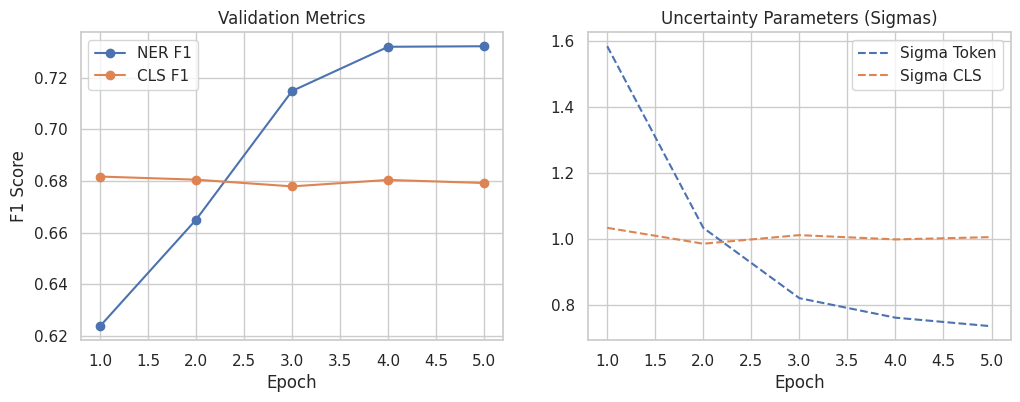

In [52]:
# ГРАФИКИ ОБУЧЕНИЯ
plt.figure(figsize=(12, 4))

# График метрик
plt.subplot(1, 2, 1)
plt.plot(df_history['epoch'], df_history['token_f1'], label='NER F1', marker='o')
plt.plot(df_history['epoch'], df_history['cls_f1'], label='CLS F1', marker='o')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# График Sigmas
plt.subplot(1, 2, 2)
plt.plot(df_history['epoch'], df_history['sigma_token'], label='Sigma Token', linestyle='--')
plt.plot(df_history['epoch'], df_history['sigma_cls'], label='Sigma CLS', linestyle='--')
plt.title('Uncertainty Parameters (Sigmas)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.show()

##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


In [47]:
# Строим функцию, которая принимает строку текста и возвращает предсказания как понятный результат: список пар (Слово, Тег) и словарь с вероятностями категорий.
def predict_joint(text: str, model, tokenizer, device, id2label, id2label_cls, threshold=0.5):
    """
    Инференс модели на одном примере.
    Параметры:
        text: str - входной текст
        model: обученная модель JointModel
        tokenizer: токенизатор из transformers
        device: устройство (CPU или GPU)
        id2label: словарь маппинга ID в метки NER
        id2label_cls: словарь маппинга ID в метки CLS
        threshold: порог для бинаризации предсказаний CLS
    Возвращает:
        ner_results: List[Tuple[str, str]] - список пар (токен, тег)
        cls_results: Dict[str, float] - словарь с классами и их вероятностями
    Примеры:
        text = "Пример текста для инференса."
        ner_results, cls_results = predict_joint(
            text=text,
            model=trained_model,
            tokenizer=tokenizer,
            device=device,
            id2label=id2label,
            id2label_cls=id2label_cls,
            threshold=0.5
        )
        >>> ner_results = [("Пример", "B-MISC"), ("текста", "I-MISC"), ...]
        >>> cls_results = {"TAKES_PLACE_IN": 0.8765, "AGE_IS": 0.6543, ...}
    """
    model.eval()
    
    # 1. Токенизация
    encoding = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True, 
        padding=True,
        max_length=512
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # 2. Прогон через модель
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # --- NER ---
        # Получаем индексы классов
        token_logits = outputs['token_logits'] # [1, Seq_Len, Num_Labels]
        pred_ids = torch.argmax(token_logits, dim=-1)[0].cpu().tolist()
        
        # --- CLS ---
        # Применяем Sigmoid для вероятностей
        cls_logits = outputs['cls_logits']     # [1, Num_Classes]
        cls_probs = torch.sigmoid(cls_logits)[0].cpu().tolist()

    # 3. Декодирование NER (Токены + Теги)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    ner_results = []
    
    for token, label_id in zip(tokens, pred_ids):
        # Пропускаем служебные токены
        if token in tokenizer.all_special_tokens:
            continue
        
        label = id2label[label_id]
        ner_results.append((token, label))

    # 4. Декодирование CLS (Класс + Вероятность)
    cls_results = {}
    for idx, prob in enumerate(cls_probs):
        if prob > threshold:
            label_name = id2label_cls[idx] if isinstance(id2label_cls, (dict, list)) else str(idx)
            cls_results[label_name] = round(prob, 4)

    return ner_results, cls_results

In [48]:
data_test = pd.read_json(
    data_test_path,
    lines=True,
)
display(data_test[['text','entities','relations']].sample(10))

,text,entities,relations
67,"В США умер двухлетний мальчик, запертый в машине пьяным отцом\n\nВ городке Офэллон штата Иллинойс в США от перегрева...","[T1\tCOUNTRY 2 5\tСША, T2\tCITY 73 80\tОфэллон, T3\tSTATE_OR_PROVINCE 87 95\tИллинойс, T4\tCOUNTRY 98 101\tСША, T5\t...","[R1\tTAKES_PLACE_IN Arg1:T32 Arg2:T1, R2\tALTERNATIVE_NAME Arg1:T32 Arg2:T33, R3\tTAKES_PLACE_IN Arg1:T33 Arg2:T2, R..."
37,"В Солсбери состоится концерт «Из России с любовью»\nЦерковь Святого Мартина в Солсбери (Church of St Martin, Salisbu...","[T1\tCITY 2 10\tСолсбери, T2\tCOUNTRY 33 39\tРоссии, T3\tEVENT 30 49\tИз России с любовью, T4\tFACILITY 51 74\tЦерко...","[R1\tLOCATED_IN Arg1:T4 Arg2:T5, R2\tLOCATED_IN Arg1:T10 Arg2:T9, R3\tPARENT_OF Arg1:T12 Arg2:T13, R4\tWORKPLACE Arg..."
90,Билл Гейтс покинул совет директоров Microsoft\nБилл Гейтс 8 ноября 2019 года\nСооснователь Microsoft 64-летний Билл ...,"[T1\tPERSON 0 10\tБилл Гейтс, T2\tORGANIZATION 19 45\tсовет директоров Microsoft, T3\tPERSON 46 56\tБилл Гейтс, T4\t...","[R1\tAGE_IS Arg1:T7 Arg2:T6, R2\tFOUNDED_BY Arg1:T42 Arg2:T7, R3\tAGENT Arg1:T1 Arg2:T5, R4\tAGENT Arg1:T7 Arg2:T52,..."
53,У Сергея Безрукова родился сын\nАнна Матисон и Сергей Безруков\nВ семье Народного артиста России Сергея Безрукова и ...,"[T1\tPERSON 2 18\tСергея Безрукова, T2\tPERSON 31 43\tАнна Матисон, T3\tPERSON 46 61\tСергей Безруков, T4\tPROFESSIO...","[R1\tPARTICIPANT_IN Arg1:T1 Arg2:T30, R2\tWORKS_AS Arg1:T5 Arg2:T4, R3\tORIGINS_FROM Arg1:T5 Arg2:T32, R4\tAWARDED_W..."
5,Скончался Евгений Евтушенко\n\nЕвгений Евтушенко\nВ США на 85 году жизни скончался поэт Евгений Евтушенко.\n\nОб это...,"[T1\tPERSON 10 27\tЕвгений Евтушенко, T2\tPERSON 29 46\tЕвгений Евтушенко, T3\tCOUNTRY 49 52\tСША, T4\tAGE 53 63\tна...","[R1\tWORKS_AS Arg1:T51 Arg2:T57, R2\tAGE_DIED_AT Arg1:T7 Arg2:T4, R3\tMEDICAL_CONDITION Arg1:T13 Arg2:T69, R4\tKNOWS..."
89,"Умер создатель индастриала Дженезис Пи-Орридж\nДженезис Пи-Орридж\nВ субботу, 14 марта 2020 года, умер Дженезис Пи-О...","[T1\tEVENT 96 100\tумер, T2\tPERSON 27 45\tДженезис Пи-Орридж, T3\tPERSON 46 64\tДженезис Пи-Орридж, T4\tDATE 67 94\...","[R1\tPARTICIPANT_IN Arg1:T2 Arg2:T19, R2\tORIGINS_FROM Arg1:T5 Arg2:T6, R3\tWORKS_AS Arg1:T5 Arg2:T20, R4\tWORKS_AS ..."
61,"США арестовали китайца за промышленный шпионаж\nНефтеперерабатывающий завод Humber, принадлежащий компании Phillips ...","[T1\tCOUNTRY 0 3\tСША, T2\tNATIONALITY 15 22\tкитайца, T3\tORGANIZATION 118 138\tМинистерство юстиции, T4\tFACILITY ...","[R1\tPARTICIPANT_IN Arg1:T2 Arg2:T46, R2\tAGENT Arg1:T1 Arg2:T46, R3\tCONVICTED_OF Arg1:T2 Arg2:T48, R4\tALTERNATIVE..."
14,"В России хотят понизить градус водки до 37,5\n\nВодка\nВ России предложили законодательно снизить минимальный градус...","[T1\tCOUNTRY 2 8\tРоссии, T2\tPERCENT 37 44\tдо 37,5, T3\tCOUNTRY 54 60\tРоссии, T4\tPERCENT 120 136\tдо 37,5 процен...","[R1\tDATE_OF_CREATION Arg1:T6 Arg2:T5, R2\tWORKPLACE Arg1:T7 Arg2:T11, R3\tWORKPLACE Arg1:T12 Arg2:T11, R4\tWORKS_AS..."
92,"Умер Эдуард Лимонов\nЭдуард Лимонов\nВо вторник, 17 марта 2020 года, умер Эдуард Лимонов. Ему было 77 лет.\n\nОб это...","[T2\tDATE 35 65\tВо вторник, 17 марта 2020 года, T3\tPERSON 72 86\tЭдуард Лимонов, T4\tAGE 97 103\t77 лет, T5\tPROFE...","[R1\tPARTICIPANT_IN Arg1:T40 Arg2:T39, R2\tPARTICIPANT_IN Arg1:T3 Arg2:T42, R3\tPOINT_IN_TIME Arg1:T42 Arg2:T2, R4\t..."
46,Полноценная встреча Трампа с Путиным не состоится из-за Макрона\nДональд Трамп и Владимир Путин 16 июля 2018 года\nН...,"[T1\tPERSON 20 26\tТрампа, T2\tPERSON 29 36\tПутиным, T3\tPERSON 56 63\tМакрона, T4\tPERSON 64 77\tДональд Трамп, T5...","[R1\tALTERNATIVE_NAME Arg1:T1 Arg2:T4, R2\tALTERNATIVE_NAME Arg1:T2 Arg2:T5, R3\tWORKPLACE Arg1:T52 Arg2:T68, R4\tWO..."


In [51]:
# Тестируем функцию на нескольких примерах
examples = [
    "Билл Гейтс покинул совет директоров Microsoft", # [T1\tPERSON 0 10\tБилл Гейтс, T2\tORGANIZATION 19 45\tсовет директоров Microsoft, T3\tPERSON 46 56\tБилл Гейтс, [R1\tAGE_IS Arg1:T7 Arg2:T6, R2\tFOUNDED_BY Arg1:T42 Arg2:T7, R3\tAGENT Arg1:T1 Arg2:T5, R4\tAGENT Arg1:T7 Arg2:
    "У Турции есть записи убийства журналиста в саудовском посольстве", # [T1\tCOUNTRY 2 8\tТурции, T2\tCOUNTRY 43 53\tсаудовском, T3\tORGANIZATION 82 101\tThe Washington Post, [R1\tOWNER_OF Arg1:T2 Arg2:T38, R2\tTAKES_PLACE_IN Arg1:T52 Arg2:T38, R3\tWORKS_AS Arg1:T6 Arg2:T5, R4\tPARTICIPANT_
    "Вчера в возрасте 90 лет во Франции умер шведский актёр Макс фон Сюдов",# [T1\tPROFESSION 10 15\tактёр, T2\tEVENT 777 784\tродился, T3\tAGE 63 69\t90 лет, T4\tCOUNTRY 73 80\tФранции, [R1\tWORKS_AS Arg1:T45 Arg2:T1, R2\tPARTICIPANT_IN Arg1:T45 Arg2:T44, R3\tORIGINS_FROM Arg1:T6 Arg2:T5, R4\tWORKS_AS
    "Экс-президента Мексики обвинили в получении взятки от наркобарона", # [T1\tEVENT 610 622\tдавал взятку, T2\tPROFESSION 54 65\tнаркобарона, T3\tPERSON 66 84\tЭнрике Пенья Ньето, T4\tPERSO  [R1\tWORKPLACE Arg1:T27 Arg2:T37, R2\tCONVICTED_OF Arg1:T27 Arg2:T38, R3\tPARTICIPANT_IN Arg1:T2 Arg2:T38, R4\tALTER
    "Банк Тинькофф запустил новую акцию для инвесторов.",          
    "В Кремле прошли переговоры между Путиным и Си Цзиньпином.",   
    "Иванов Иван Иванович не пришел на работу.",                   
    "Операция 'Буря в пустыне' началась в 1991 году."
]

print("=== Качественный анализ ===")
for text in examples:
    ner_res, cls_res = predict_joint(text, model_ner, tokenizer, device, id2label, id2label_cls)
    
    sorted_cls_res = dict(sorted(cls_res.items(), key=lambda item: item[1], reverse=True))
    print(f"\nText: {text}")
    print(f"CLS Predictions: {sorted_cls_res}")
    print("NER Entities:")
    # Красивый вывод NER (склеиваем токены обратно, если это subwords)
    for token, tag in ner_res:
        if tag != 'O': # Выводим только сущности для краткости
            print(f"  {token:<15} -> {tag}")

=== Качественный анализ ===

Text: Билл Гейтс покинул совет директоров Microsoft
CLS Predictions: {'ALTERNATIVE_NAME': 0.8458, 'WORKS_AS': 0.7673, 'PARTICIPANT_IN': 0.7611, 'POINT_IN_TIME': 0.7298, 'WORKPLACE': 0.712, 'HEADQUARTERED_IN': 0.6714, 'TAKES_PLACE_IN': 0.6545, 'ORIGINS_FROM': 0.625, 'AGE_IS': 0.6057, 'AGENT': 0.5899}
NER Entities:
  Билл            -> B-PER
  Гейтс           -> I-PER
  покинул         -> B-EVENT
  совет           -> B-ORG
  директоров      -> I-PROFESSION
  Microsoft       -> B-ORG

Text: У Турции есть записи убийства журналиста в саудовском посольстве
CLS Predictions: {'ALTERNATIVE_NAME': 0.8434, 'PARTICIPANT_IN': 0.7602, 'WORKS_AS': 0.7505, 'WORKPLACE': 0.7411, 'POINT_IN_TIME': 0.7223, 'LOCATED_IN': 0.6491, 'ORIGINS_FROM': 0.6458, 'TAKES_PLACE_IN': 0.6328, 'HEADQUARTERED_IN': 0.63, 'AGE_IS': 0.5639, 'AGENT': 0.5455}
NER Entities:
  Турции          -> B-LOC
  убийства        -> B-EVENT
  журналиста      -> B-PROFESSION
  саудов          -> B-LOC
  ##ском   

Выводы:
  
Работа с субтокенами (Subwords):  
Модель «склеивает» разорванные токенизатором слова в основном корректно, но ошибки есть  
Пример: Тинь + ##кофф → B-ORG, I-ORG.  
Пример: саудов + ##ском → B-LOC, B-LOC (тут ошибка с тегом B вместо I).  
Пример: Си + Цзинь + ##пин + ##ом -> B-PER, I-PER, I-PER, I-PER  
Пример: Экс + "-" + президента -> B-PROFESSION, B-PROFESSION, B-PROFESSION (тут ошибка с тегом B вместо I)  
Пример: Операция + ' + Буря + в + пустыне + ' -> B-MISC, I-MISC, I-MISC, I-MISC, I-EVENT (тут ошибка с тегом I-EVENT вместо MISK)  
Глубокое понимание контекста:  
  
Турция, Саудовском, Франция, Мексики -> LOC определено верно  
Шведский, Кремле, -> NATIONALITY, ORG определено верно  
Макс фон Сюдов, Путиным, Си Цзиньпином -> PER определено верно  
Покинул, убийства, умер, переговоры -> EVENT определено верно, но: обвинили, запустил - не определено как EVENT  
«Совет директоров»: Выделено как Организация/Профессия (B-ORG + I-PROFESSION). Это сложный кейс, и модель не справилась
Числительные: 90 и 1991 корректно различены как AGE (возраст) и DATE (дата) благодаря контексту (лет vs году).
Видны ошибки в сочетании метки "B" или "I" с тегами например PER, EVENT ...
  
Анализ CLS (Классификация связей/тем)
Здесь наблюдается серьезная проблема, которую не было видно на сухих цифрах F1-score.  
Проблема 1: "Залипание" на мажоритарных классах (Bias).  
Предсказания для всех примеров почти идентичны:  
ALTERNATIVE_NAME: везде 0.82 - 0.88 (даже для "Банк Тинькофф" или "Иванов не пришел").
PARTICIPANT_IN: везде 0.76 - 0.80.
WORKS_AS: везде 0.73 - 0.76.  
Это значит, что классификатор не выучил специфику текстов, а просто выучил частотное распределение меток в датасете.
Значит текущая архитектура (JointModel с одним CLS-токеном) не подходит. Нужно подавать в модель пары сущностей (entity markers)

##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!